# Blackhole emission models

`synthesizer` can utilise several different black hole emission models, i.e. a model that translates a set of physical properties to one or several spectral energy distributions. 

In [1]:
from synthesizer.blackholes import UnifiedAGN
import matplotlib.pyplot as plt
import numpy as np
from unyt import deg

### `Template` model

Our simplest model is to just provide a template, either directly or from a file. This is simply scaled by the blackhole bolometric luminosity to produce the spectra.

### `UnifiedAGN` model

Our default model is the `UnifiedAGN` model. This combines a disc model with a model for the NLR, BLR, and torus.

This model is initialised with a `disc_model` (by default we use the model of Kubota and Done 2019  (https://ui.adsabs.harvard.edu/abs/2018MNRAS.480.1247K/abstract) and any additional fixed parameters.

In [2]:
grid_dir = '../../../tests/test_grid/'
emission_model = UnifiedAGN(disc_model='test_grid_agn', photoionisation_model='', grid_dir=grid_dir)

There are various parameter lists associated with this model, e.g.

In [3]:
emission_model.disc_parameters

['mass', 'accretion_rate_eddington', 'cosine_inclination']

The parameters of the grid(s):

In [4]:
emission_model.grid_parameters

['mass',
 'accretion_rate_eddington',
 'cosine_inclination',
 'metallicity',
 'ionisation_parameter',
 'hydrogen_density']

All parameters:

In [5]:
emission_model.parameters

['covering_fraction_nlr',
 'ionisation_parameter_nlr',
 'hydrogen_density_nlr',
 'ionisation_parameter_blr',
 'theta_torus',
 'covering_fraction_blr',
 'velocity_dispersion_nlr',
 'bolometric_luminosity',
 'accretion_rate_eddington',
 'velocity_dispersion_blr',
 'hydrogen_density_blr',
 'metallicity',
 'cosine_inclination',
 'mass']

Parameters fixed at initialisation:

In [6]:
emission_model.fixed_parameters

['ionisation_parameter_blr',
 'hydrogen_density_blr',
 'covering_fraction_blr',
 'velocity_dispersion_blr',
 'ionisation_parameter_nlr',
 'hydrogen_density_nlr',
 'covering_fraction_nlr',
 'velocity_dispersion_nlr',
 'theta_torus']

Variable parameters which are need to be provided by the call to `get_spectra` etc.

In [7]:
emission_model.variable_parameters

['bolometric_luminosity',
 'accretion_rate_eddington',
 'metallicity',
 'cosine_inclination',
 'mass']

For the UnifiedAGN model a handful of spectra can be created (and returned) if desired:

In [8]:
emission_model.available_spectra

['disc_incident_isotropic',
 'disc_incident',
 'disc_escape',
 'disc_transmitted',
 'disc',
 'nlr',
 'blr',
 'torus',
 'intrinsic']

#### Generating spectra

We can generate spectra using the get_spectra command and passing the necessary parameters. In this case the blackhole mass, the accretion rate expressed as a fraction of the Eddington rate (`accretion_rate_eddington`), and the cosine of the inclination (`cosine_inclination`).  Other disc models have different parameters.

In [9]:
parameters_dict, spectra = emission_model.get_spectra(mass=1E9, accretion_rate_eddington=1., cosine_inclination=0.5, metallicity=0.01)

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Note, the combined spectra from the AGN is labelled as "intrinsic". While moderately confusing this is to align with the labelling of stellar population spectra. When associated with a galaxy the "emergent", "dust", and "total" spectra can be generated if diffuse dust attenuation (and emission) is specified.

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


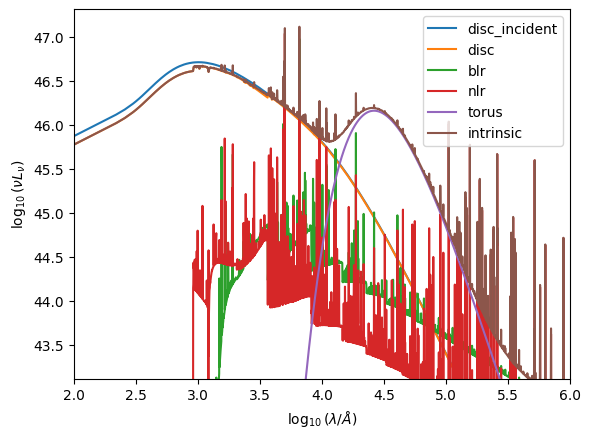

In [10]:
for id in ['disc_incident', 'disc', 'blr', 'nlr', 'torus', 'intrinsic']:

    sed = spectra[id]

    plt.plot(np.log10(sed.lam), np.log10(sed.luminosity), label = id)

plt.xlim([2,6])
plt.ylim(np.max(np.log10(sed.luminosity))-4, np.max(np.log10(sed.luminosity))+0.2)
plt.xlabel(r'$\log_{10}(\lambda/\AA)$')
plt.ylabel(r'$\log_{10}(\nu L_{\nu})$')
plt.legend()
plt.show()

#### Inclination dependence

When the inclination is high ($>90^{\circ}-\theta_{torus}$) the disc and BLR are assumed to be entirely obscured by the dusty torus. In this case the emission from the disc and BLR is set to zero.

In addition some disc models (e.g. AGNSED) have a dependence on the inclination. This effects the emission observed from the disc but not how the NLR, BLR, and torus are illuminated.

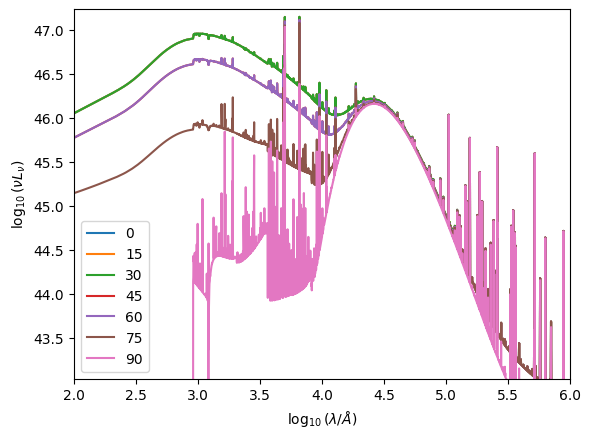

In [11]:
for inclination in [0, 15, 30, 45, 60, 75, 90]:
    cosine_inclination = np.cos((inclination*deg).to_value('rad'))
    parameters_dict, spectra = emission_model.get_spectra(mass=1E9, accretion_rate_eddington=1., cosine_inclination=cosine_inclination, metallicity=0.01)
    
    sed = spectra['intrinsic']
    plt.plot(np.log10(sed.lam), np.log10(sed.luminosity), label = inclination)

plt.xlim([2,6])
plt.ylim(np.max(np.log10(sed.luminosity))-4, np.max(np.log10(sed.luminosity))+0.2)
plt.xlabel(r'$\log_{10}(\lambda/\AA)$')
plt.ylabel(r'$\log_{10}(\nu L_{\nu})$')
plt.legend()
plt.show()